1. Data Generation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / tf.cast(N, dtype=DTYPE)
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i, N_grid = 5000, 300, 300, 200

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
w_f = tf.random.uniform((N_f, 1), w_min, w_max, dtype=DTYPE)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.random.uniform((N_b, 1), w_min, w_max, dtype=DTYPE)
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
w_i = tf.random.uniform((N_i, 1), w_min, w_max, dtype=DTYPE)

x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)

# grid for normalization penalty
x_n = tf.linspace(x_min, x_max, N_grid)[:, None]
x_ns = scale_inputs(x_n, x_min, x_max)

In [2]:
# check shapes and data types
print(tf.shape(x_is))
print(x_is.dtype)
print(tf.shape(t_is))
print(t_is.dtype)
print(tf.shape(w_is))
print(w_is.dtype)

print(tf.shape(x_bs))
print(x_bs.dtype)
print(tf.shape(t_bs))
print(t_bs.dtype)
print(tf.shape(w_bs))
print(w_bs.dtype)

print(tf.shape(x_fs))
print(x_fs.dtype)
print(tf.shape(t_fs))
print(t_fs.dtype)
print(tf.shape(w_fs))
print(w_fs.dtype)

print(tf.shape(x_ns))
print(x_ns.dtype)

tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([300   1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([5000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([5000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([5000    1], shape=(2,), dtype=int32)
<dtype: 'float64'>
tf.Tensor([200   1], shape=(2,), dtype=int32)
<dtype: 'float64'>


In [ ]:
# plot data points

# plotting collocation, boundary, and initial points
# plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
# plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
# plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('Unscaled Inputs')
# plt.legend(loc='upper right')
# plt.show()

plt.scatter(x_fs, t_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_bs, t_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, t_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

# plt.scatter(x_f, w_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
# plt.scatter(x_b, w_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
# plt.scatter(x_i, w_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
# plt.xlabel('x')
# plt.ylabel('w')
# plt.title('Unscaled Inputs')
# plt.legend(loc='upper right')
# plt.show()

plt.scatter(x_fs, w_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_bs, w_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, w_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('w')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

2. Model Architecture

In [3]:
# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense6 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense7 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense8 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

3. Loss function

In [4]:
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, w):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            xs = scale_inputs(x, x_min, x_max)
            ts = scale_inputs(t, t_min, t_max)
            ws = scale_inputs(w, w_min, w_max)
            X = tf.concat([xs, ts, ws], axis=1)
            # uv = tf.clip_by_value(model(X), -1e2, 1e2) # prevent extreme values
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x) #, unconnected_gradients='zero')
        v_x = tape1.gradient(v, x) #, unconnected_gradients='zero')
        u_t = tape1.gradient(u, t) #, unconnected_gradients='zero')
        v_t = tape1.gradient(v, t) #, unconnected_gradients='zero')
    u_xx = tape2.gradient(u_x, x) #, unconnected_gradients='zero')
    v_xx = tape2.gradient(v_x, x) #, unconnected_gradients='zero')
    del tape1, tape2

    potential = 0.5 * w**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def norm_loss(model, x_ns, N_t, w_val=1.0):
    w_n = tf.ones_like(x_ns) * w_val
    w_ns = scale_inputs(w_n, w_min, w_max)
    t_n = tf.random.uniform((N_t, 1), t_min, t_max, dtype=DTYPE)
    t_ns = scale_inputs(t_n, t_min, t_max)
    norm_penalty_total = 0.0
    for t_val in tf.unstack(t_ns, axis=0):
        t_in = tf.ones_like(x_ns) * t_val
        X = tf.concat([x_ns, t_in, w_ns], axis=1)
        uv = model(X)
        dx = (x_max - x_min) / tf.cast(tf.shape(x_ns)[0], dtype=DTYPE)
        norm = tf.reduce_sum(tf.math.abs(uv)**2) * dx
        norm_penalty_total += tf.square(norm - 1.0)
    norm_penalty = norm_penalty_total / tf.cast(N_t, dtype=DTYPE)

    return norm_penalty

@tf.function
def loss_fn(model, interior, boundary, initial, omega, norm_grid):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    w_f, w_b, w_i = omega
    x_grid, N_t, w_val = norm_grid

    f_u, f_v = pde_residual(model, x_f, t_f, w_f)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v)) # / tf.cast(tf.shape(x_f)[0], dtype=DTYPE)

    uv_b = model(tf.concat([x_b, t_b, w_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2])) # / tf.cast(tf.shape(x_b)[0], dtype=DTYPE)

    uv_i = model(tf.concat([x_i, t_i, w_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i))) # / tf.cast(tf.shape(x_i)[0], dtype=DTYPE)
    
    norm_penalty = norm_loss(model, x_grid, N_t, w_val)
    
    return loss_f + loss_b + loss_i + 10.0*norm_penalty, (loss_f, loss_b, loss_i, 10.0*norm_penalty)

In [5]:
# Create the model
model = PINN(input_dim=3, mapping_size=512, scale=10.0)

# Save the model in Keras format
model_test_path = 'model_test_v3.keras'
model.save(model_test_path)
print(f"Model saved to {model_test_path}")

# Load the model
loaded_model = tf.keras.models.load_model(model_test_path, custom_objects={'PINN': PINN})

# Dummy input to build the model (batch size 1, input_dim = 2)
dummy_input = tf.concat([x_f[:5], t_f[:5], w_f[:5]], axis=1)
_ = loaded_model(dummy_input)

loaded_model.summary()

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\saving\saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model saved to model_test_v3.keras


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_1         │ ?                      │         1,536 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (5, 512)               │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (5, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (5, 2)                 │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,365,954 (18.05 MB)

 Trainable params: 2,364,418 (18.04 MB)

 Non-trainable params: 1,536 (12.00 KB)

4. Learning rate and Train step function

In [6]:
# Define the Optimizer
# Learning rate schedule with exponential decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.9,
    staircase=True
)

# ADAM optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, w_f, w_b, w_i, x_n, N_t, w_val):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li, ln) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), (w_f, w_b, w_i), (x_n, N_t, w_val))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li, ln)

5. Training Loop

Epoch 0: Loss = 6.42397e+01 (f = 6.035e+01, b = 2.269e-01, i = 3.509e-01), n = 3.314e+00)


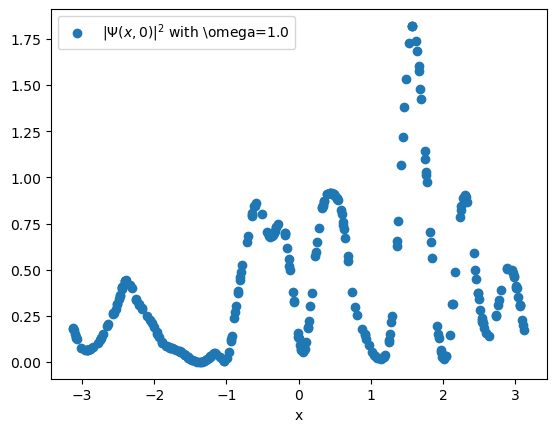

Best model saved to best_model_v4.keras at epoch 0 with loss 64.23969872634501
Best model saved to best_model_v4.keras at epoch 3 with loss 40.35119110267247
Best model saved to best_model_v4.keras at epoch 4 with loss 22.47148642087157
Best model saved to best_model_v4.keras at epoch 5 with loss 15.22173876070069
Best model saved to best_model_v4.keras at epoch 6 with loss 11.211144538907138
Best model saved to best_model_v4.keras at epoch 7 with loss 10.341285150627831
Best model saved to best_model_v4.keras at epoch 8 with loss 7.840442332355403
Best model saved to best_model_v4.keras at epoch 10 with loss 7.392095908009467
Best model saved to best_model_v4.keras at epoch 11 with loss 6.230646583665915
Best model saved to best_model_v4.keras at epoch 12 with loss 4.8562840517540495
Best model saved to best_model_v4.keras at epoch 14 with loss 3.9222350854358603
Best model saved to best_model_v4.keras at epoch 15 with loss 2.875869965366388
Best model saved to best_model_v4.keras at 

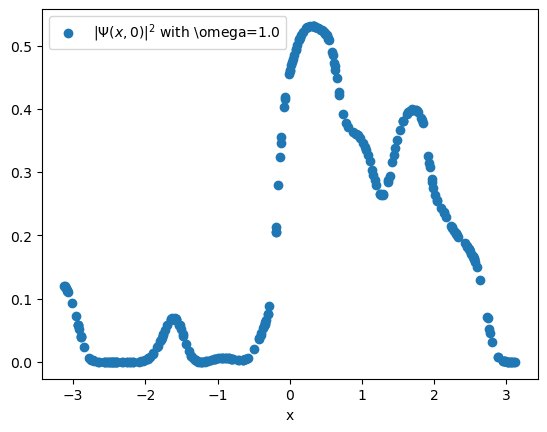

Best model saved to best_model_v4.keras at epoch 539 with loss 0.07468593995712636
Best model saved to best_model_v4.keras at epoch 564 with loss 0.0645436900525883
Best model saved to best_model_v4.keras at epoch 565 with loss 0.06142796254063654
Best model saved to best_model_v4.keras at epoch 570 with loss 0.056509574579761135
Best model saved to best_model_v4.keras at epoch 588 with loss 0.05038837708198341
Best model saved to best_model_v4.keras at epoch 593 with loss 0.04955647020522098
Best model saved to best_model_v4.keras at epoch 594 with loss 0.042162851739014795
Best model saved to best_model_v4.keras at epoch 600 with loss 0.04150510280535116
Best model saved to best_model_v4.keras at epoch 601 with loss 0.03357760803369447
Best model saved to best_model_v4.keras at epoch 602 with loss 0.03092307625765643
Best model saved to best_model_v4.keras at epoch 605 with loss 0.030060827990122746
Best model saved to best_model_v4.keras at epoch 608 with loss 0.02800511783948849
Be

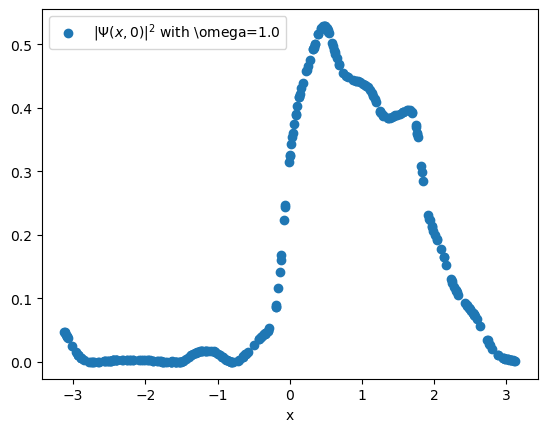

Best model saved to best_model_v4.keras at epoch 1016 with loss 0.001992727562661783
Best model saved to best_model_v4.keras at epoch 1022 with loss 0.0017502951075329756
Best model saved to best_model_v4.keras at epoch 1024 with loss 0.0016573754822301512
Best model saved to best_model_v4.keras at epoch 1027 with loss 0.0015912070677058256
Best model saved to best_model_v4.keras at epoch 1029 with loss 0.0013971116543421448
Best model saved to best_model_v4.keras at epoch 1046 with loss 0.001233408151608795
Best model saved to best_model_v4.keras at epoch 1050 with loss 0.0011996728877564332
Best model saved to best_model_v4.keras at epoch 1053 with loss 0.0011585730425965682
Best model saved to best_model_v4.keras at epoch 1063 with loss 0.0009968200362721197
Best model saved to best_model_v4.keras at epoch 1066 with loss 0.0009561612507659599
Best model saved to best_model_v4.keras at epoch 1067 with loss 0.0009283877625338114
Best model saved to best_model_v4.keras at epoch 1068 wi

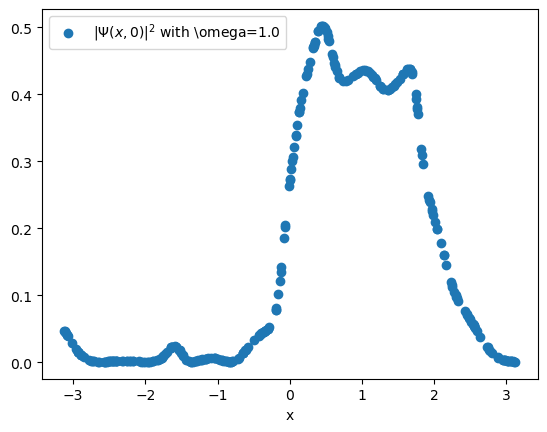

Early stopping at epoch 1670 as loss did not improve for 500 epochs.
Training stopped at epoch 1670 with loss 6.8646078542205435
Total training time: 3:49:12


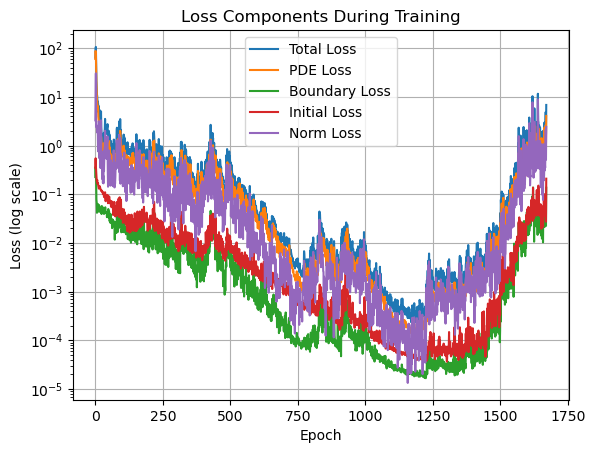


Weights match.
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!


In [7]:
# Instantiate the Model
pinn = PINN(input_dim=3, mapping_size=512, scale=10.0)

# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 500
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": [],
    "norm" : []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_v4.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li, ln) = train_step(pinn, x_f, t_f, x_bs, t_bs, x_is, t_is, psi_i, w_f, w_bs, w_is, x_ns, 15, 1.0)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())
    train_loss_results["norm"].append(ln.numpy())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e}), n = {ln.numpy().item():.3e})")

        w_test = tf.ones_like(x_is)
        w_test_s = scale_inputs(w_test, w_min, w_max)
        X = tf.concat([x_is, t_is, w_test_s], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        # test_Re, test_Im = normalization(x_min, x_max, N_i, u, v)
        density = u**2 + v**2

        plt.scatter(x_i, density, label=r'$|\Psi(x,0)|^2$ with \omega=1.0')
        plt.xlabel('x')
        plt.legend()
        plt.show()
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch} with loss {loss.numpy()}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.plot(train_loss_results["norm"], label="Norm Loss")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

In [8]:
import csv

# Save to CSV
with open("train_loss_results_v4.csv", "w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["epoch", "total_loss", "pde_loss", "boundary_loss", "initial_loss", "norm_loss"])
    
    # Write data row by row
    for epoch, (total, pde, boundary, initial, norm) in enumerate(zip(
        train_loss_results["total"],
        train_loss_results["pde"],
        train_loss_results["boundary"],
        train_loss_results["initial"],
        train_loss_results["norm"]
    )):
        writer.writerow([epoch, total, pde, boundary, initial, norm])


In [9]:
import pandas as pd

df = pd.read_csv("train_loss_results_v4.csv")
print(df.head())
print(df.tail())

   epoch  total_loss   pde_loss  boundary_loss  initial_loss  norm_loss
0      0   64.239699  60.347477       0.226927      0.350883   3.314411
1      1  100.464462  88.205922       0.367888      0.550774  11.339878
2      2  106.762734  75.502976       0.249672      0.370960  30.639125
3      3   40.351191  37.440427       0.180696      0.304097   2.425971
4      4   22.471486  19.541142       0.078743      0.229648   2.621953
      epoch  total_loss  pde_loss  boundary_loss  initial_loss  norm_loss
1666   1666    1.676490  1.197348       0.036690      0.089997   0.352454
1667   1667    2.821409  1.801504       0.066877      0.087938   0.865089
1668   1668    4.915774  2.647099       0.051252      0.066800   2.150623
1669   1669    1.730445  1.165849       0.022499      0.027466   0.514631
1670   1670    6.864608  4.081431       0.137123      0.210120   2.435934


6. Loading the Model

Normalization check for the initial condition: $|\Psi(x,0)|**2=0.9288133585984614$
Model loaded successfully


Model: "pinn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_4         │ ?                      │         1,536 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (5000, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (5000, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (5000, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,365,954 (18.05 MB)

 Trainable params: 2,364,418 (18.04 MB)

 Non-trainable params: 1,536 (12.00 KB)

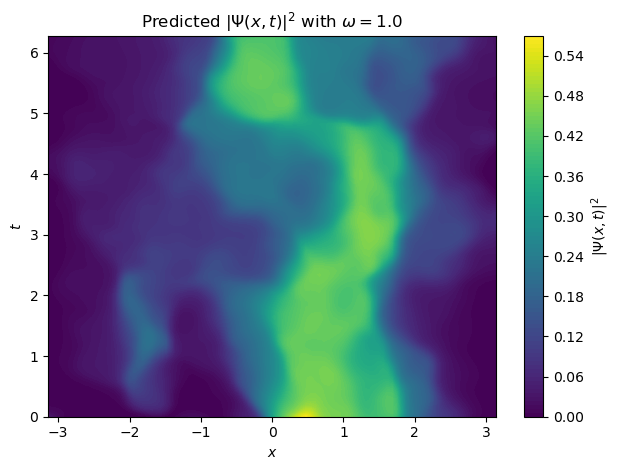

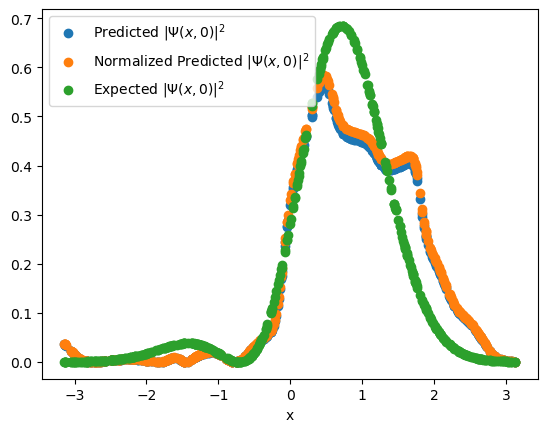

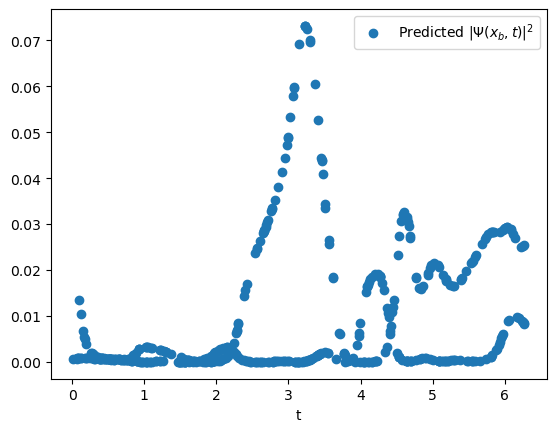

In [10]:
############################## Loading the model ##############################

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / N
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(2.0*w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 500, 500
w_test = 1.0

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
w_f = tf.ones_like(x_f) * w_test
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.ones_like(x_b) * w_test
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)

w_i = tf.ones_like(x_i) * w_test
psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)
# psi_i_Re, psi_i_Im = normalization(x_min, x_max, N_i, tf.math.real(psi_i), tf.math.imag(psi_i))
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

# verify normalization
dx_i = (x_max - x_min) / N_i
norm_check = tf.reduce_sum(tf.math.abs(psi_i)**2) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense5 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense6 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense7 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense8 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# Load the model
loaded_model = tf.keras.models.load_model('best_model_v4.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

################## Plot: Contour Plot ###############################

# Contour Plot
N = 100
x_plot = np.linspace(x_min, x_max, N)[:,None]
t_plot = np.linspace(t_min, t_max, N)[:,None]
x_plot_scaled = scale_inputs(x_plot, x_min, x_max)
t_plot_scaled = scale_inputs(t_plot, t_min, t_max)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

x_plot_in = tf.convert_to_tensor(x_plot_scaled, dtype=DTYPE)
t_plot_in = tf.convert_to_tensor(t_plot_scaled, dtype=DTYPE)
w_plot = tf.ones_like(x_plot_in) * w_test
w_plot_in = scale_inputs(w_plot, w_min, w_max)

density_interior = []

count = 0
for t_val in tf.unstack(t_plot_in, axis=0):
    t_in = tf.ones_like(x_plot_in) * t_val
    input = tf.concat([x_plot_in, t_in, w_plot_in], axis=1)
    uv = loaded_model(input)
    u, v = uv[:, 0], uv[:, 1]
    density = u**2 + v**2
    # psi_Re, psi_Im = normalization(x_min, x_max, N, u, v)
    # density = psi_Re**2 + psi_Im**2
    density_interior.append(density)

# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_interior, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(f'Predicted $|\Psi(x,t)|^2$ with $\omega={w_test}$')
plt.tight_layout()
plt.show()

################## Plot: Initial Condition ###############################

X = tf.concat([x_is, t_is, w_is], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N_i, u, v)
density_initial = psi_Re**2 + psi_Im**2

plt.scatter(x_i, u**2 + v**2, label=r'Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, density_initial, label=r'Normalized Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, tf.math.abs(psi_i)**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

################## Plot: Boundary Condition ###############################

X = tf.concat([x_bs, t_bs, w_bs], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
density_boundary = psi_Re**2 + psi_Im**2

plt.scatter(t_b, u**2 + v**2, label=r'Predicted $|\Psi(x_b,t)|^2$')
# plt.scatter(t_b, density_boundary, label=r'Normalized Predicted $|\Psi(x_b,t)|^2$')
plt.xlabel('t')
plt.legend()
plt.show()

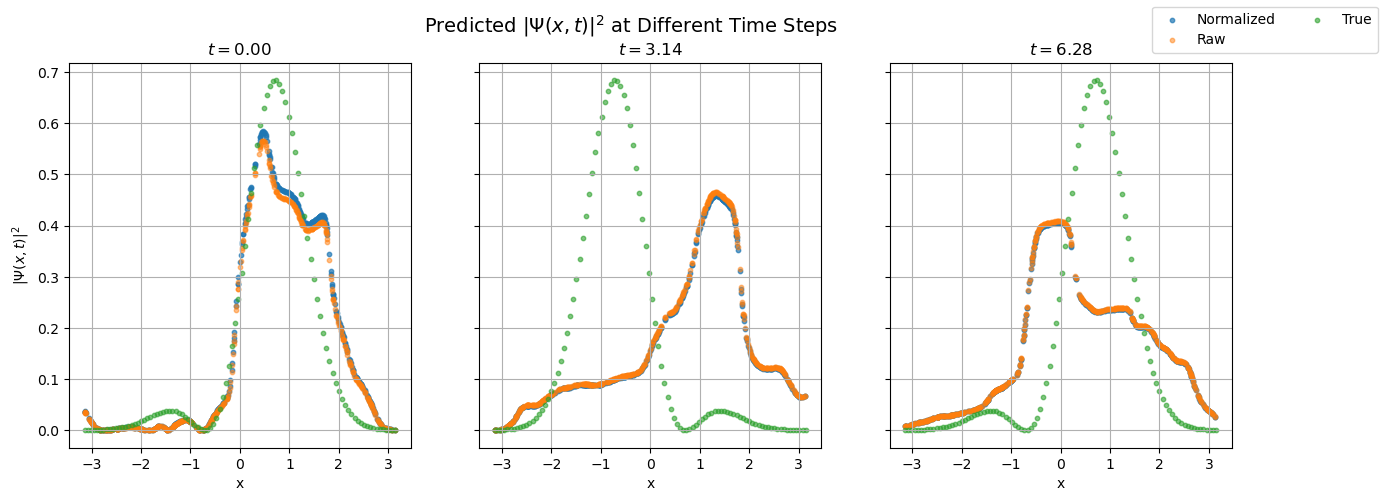

In [11]:
x_true = np.linspace(x_min, x_max, 100)

# Compute theoretical |Psi(x,t)|^2 as before
def U_0(x, t):
    w = 1.0
    return np.exp(-1j * 0.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0)

def U_1(x, t):
    w = 1.0
    return np.exp(-1j * 1.5 * w * t) * (w/np.pi)**0.25 * np.exp(-w * x**2 / 2.0) * x * np.sqrt(2.0*w)

# Define time steps
t_test = [0, np.pi, 2.0*np.pi]

# Create subplots
fig, axs = plt.subplots(1, len(t_test), figsize=(15, 5), sharey=True)

for i, t_val in enumerate(t_test):
    t_in = tf.ones_like(x_is) * t_val
    t_ins = scale_inputs(t_in, t_min, t_max)
    X = tf.concat([x_is, t_ins, w_bs], axis=1)
    uv = loaded_model(X)
    u, v = uv[:, 0:1], uv[:, 1:2]
    psi_Re, psi_Im = normalization(x_min, x_max, N_b, u, v)
    density = psi_Re**2 + psi_Im**2

    t_true = np.ones_like(x_true) * t_val
    psi_true = (1.0 / np.sqrt(2.0)) * (U_0(x_true, t_true) + U_1(x_true, t_true))
    density_true = np.abs(psi_true)**2

    ax = axs[i]
    ax.scatter(x_i, density, s=10, label="Normalized", alpha=0.7)
    ax.scatter(x_i, u**2 + v**2, s=10, label="Raw", alpha=0.5)
    ax.scatter(x_true, density_true, s=10, label="True", alpha=0.6)
    ax.set_title(f"$t = {t_val:.2f}$")
    ax.set_xlabel("x")
    if i == 0:
        ax.set_ylabel(r"$|\Psi(x,t)|^2$")
    ax.grid(True)

# Add a single legend and adjust layout
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=2)
fig.suptitle("Predicted $|\Psi(x,t)|^2$ at Different Time Steps", fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

Text(0.5, 1.0, 'Max Amplitude over Time')

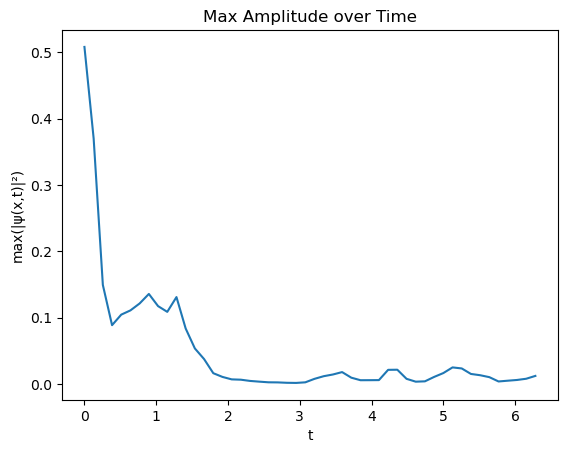

In [12]:
max_amplitudes = []
t_eval = np.linspace(t_min, t_max, 50)
for t_val in t_eval:  # t_eval = list of times like [0, pi, 2pi]
    x_grid = np.linspace(x_min, x_max, 300).reshape(-1, 1)
    t_grid = np.full_like(x_grid, t_val)
    inputs = tf.concat([
        scale_inputs(x_grid, x_min, x_max),
        scale_inputs(t_grid, t_min, t_max),
        tf.ones_like(x_grid)  # Assuming w=0 for plotting or same value
    ], axis=1)
    pred = loaded_model(inputs)
    psi = pred[:, 0]**2 + pred[:, 1]**2
    max_amplitudes.append(tf.reduce_max(psi).numpy())

plt.plot(t_eval, max_amplitudes)
plt.xlabel("t")
plt.ylabel("max(|ψ(x,t)|²)")
plt.title("Max Amplitude over Time")

Text(0.5, 1.0, 'PDE Residual Heatmap')

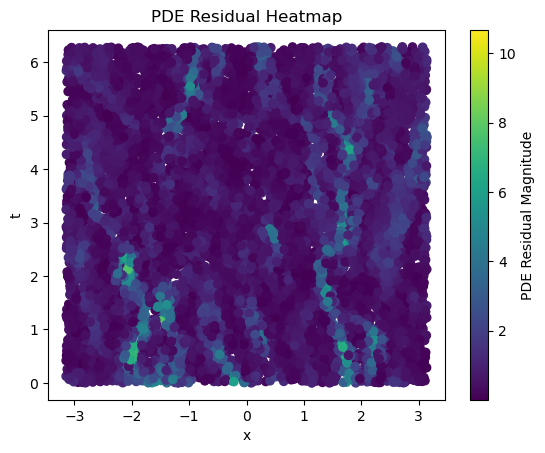

In [13]:
w_val = tf.ones_like(x_f)
f_u, f_v = pde_residual(loaded_model, x_f, t_f, w_val)
residual = tf.abs(f_u) + tf.abs(f_v)

# Optional: reshape to 2D grid if you're visualizing over mesh
plt.scatter(x_f.numpy(), t_f.numpy(), c=residual.numpy(), cmap="viridis")
plt.colorbar(label="PDE Residual Magnitude")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PDE Residual Heatmap")